In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.inspection import permutation_importance
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import linear_model
from sklearnex import patch_sklearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

patch_sklearn()
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
def smote(x, y, c):
    if c==1:
        oversample = SMOTE()
    elif c==2:
        oversample = BorderlineSMOTE()
    elif c==3:
        oversample = SVMSMOTE()
    elif c==0:
        oversample = ADASYN()

    return oversample.fit_resample(x, y)

# Read Data

In [3]:
# df = pd.read_excel("../data/newData/MergedImputed.xlsx")
df = pd.read_excel("./data/MergedImputed_TimeConstrained.xlsx")

print(len(df["Patient ID"].unique()))

544


## Drop features with more than 80% missing values

In [4]:
ignore = ['Patient ID', 'Sample Date Time','Date of Discharge']

df_dropped = df.dropna(thresh=int(len(df)*0.2),axis=1)

columns_for_dups = []
for i in list(df_dropped):
    if i in ignore:
        continue
    else:
        columns_for_dups.append(i)

print (len(df_dropped))
df_dropped = df_dropped.drop_duplicates(subset = columns_for_dups)

print (len(df_dropped))
print (set(list(df))-set(list(df_dropped)))
df_dropped
print(len(df_dropped["Patient ID"].unique()))

list(df_dropped)

16179
15648
{'Atypical Large Cell_CBC (Complete Blood Count) EDTA', 'Comment :_CBC (Complete Blood Count) EDTA', 'Metamyelocyte Cell_CBC (Complete Blood Count) EDTA', 'S Gene', 'Corrected TLC_CBC (Complete Blood Count) EDTA', 'Nucleated RBCs_CBC (Complete Blood Count) EDTA', 'N', 'ORF Gene', 'Band Cell_CBC (Complete Blood Count) EDTA', 'Blasts_CBC (Complete Blood Count) EDTA', 'SPO2 Supplimental O2', 'Comment(HbA1C)_Glycosylated Haemoglobin (HbA1C) EDTA', 'Myelocyte Cell_CBC (Complete Blood Count) EDTA'}
544


['Patient ID',
 'Sample Date Time',
 'Days to Outcome',
 'Date of Discharge',
 'Glycosylated Haemoglobin(Hb A1c)_Glycosylated Haemoglobin (HbA1C) EDTA',
 'Average Glucose Value For the Last 3 Months_Glycosylated Haemoglobin (HbA1C) EDTA',
 'Average Glucose Value For the Last 3 Months IFCC_Glycosylated Haemoglobin (HbA1C) EDTA',
 'Glycosylated Haemoglobin(Hb A1c) IFCC_Glycosylated Haemoglobin (HbA1C) EDTA',
 'Duration of Stay',
 'Gender',
 'Age',
 'Height',
 'Weight',
 'BMI',
 'Temperature',
 'BP Systolic',
 'BP Diastolic',
 'Pulse Rate',
 'SPO2 Room Air',
 'Respiration Rate',
 'Pregnancy',
 'Severity Class',
 'Mortality',
 'Binary Severity Class',
 'Hypertension',
 'Diabetes',
 'Cancer',
 'Hyperlipidemia/dislipidemia',
 'Thyroid',
 'Heart/Circulatory System',
 'Respiratory',
 'Brain/Nervous System',
 'Renal',
 'Liver',
 'Other',
 'E',
 'RdRp',
 'Steroids',
 'AntiVirals',
 '25 Hydroxy- Vitamin D  Serum_25 Hydroxy Vitamin D Level Serum',
 'Basophils_CBC (Complete Blood Count) EDTA',
 'Di

### Features to be considered

In [5]:
features = [
 'Basophils_CBC (Complete Blood Count) EDTA',
 'Eosinophils_CBC (Complete Blood Count) EDTA',
 'Haemoglobin_CBC (Complete Blood Count) EDTA',
 'Lymphocytes_CBC (Complete Blood Count) EDTA',
 'MCH_CBC (Complete Blood Count) EDTA',
 'MCHC_CBC (Complete Blood Count) EDTA',
 'MCV_CBC (Complete Blood Count) EDTA',
 'Monocytes_CBC (Complete Blood Count) EDTA',
 'Neutrophils_CBC (Complete Blood Count) EDTA',
 'Packed Cell  Volume_CBC (Complete Blood Count) EDTA',
 'Platelet Count_CBC (Complete Blood Count) EDTA',
 'RDW_CBC (Complete Blood Count) EDTA',
 'Total Leucocyte Count (TLC)_CBC (Complete Blood Count) EDTA',
 'Absolute Lymphocyte Count_CBC (Complete Blood Count) EDTA',
 'Absolute Neutrophil Count_CBC (Complete Blood Count) EDTA',
 'Absolute Monocyte Count_CBC (Complete Blood Count) EDTA',
 'RBC Count_CBC (Complete Blood Count) EDTA',
 'MPV_CBC (Complete Blood Count) EDTA',
 'Gender',
 'Age',
 'Height',
 'Weight',
 'BMI',
 'Temperature',
 'BP Systolic',
 'BP Diastolic',
 'Pulse Rate',
 'SPO2 Room Air',
 'Respiration Rate',
 'Pregnancy',
 'Hypertension',
 'Diabetes',
 'Cancer',
 'Hyperlipidemia/dislipidemia',
 'Thyroid',
 'Heart/Circulatory System',
 'Respiratory',
 'Brain/Nervous System',
 'Renal',
 'Liver',
 'Other',
 'E',
 'RdRp',
 'Absolute Eosinophil Count_CBC (Complete Blood Count) EDTA',
 'Procalcitonin Level_Procalcitonin*  Serum',
 'Absolute Basophil Count_CBC (Complete Blood Count) EDTA',
 'INR_Prothrombin Time (with INR) Citrate Plasma',
 'Prothrombin Time (PT)_Prothrombin Time (with INR) Citrate Plasma',
 'MNPT Value_Prothrombin Time (with INR) Citrate Plasma',
 'Glycosylated Haemoglobin(Hb A1c)_Glycosylated Haemoglobin (HbA1C) EDTA',
 'Average Glucose Value For the Last 3 Months_Glycosylated Haemoglobin (HbA1C) EDTA',
 'Average Glucose Value For the Last 3 Months IFCC_Glycosylated Haemoglobin (HbA1C) EDTA',
 'Glycosylated Haemoglobin(Hb A1c) IFCC_Glycosylated Haemoglobin (HbA1C) EDTA',
 'Trop I_Trop I Serum (High Sensitive)',
 'CK-MB (Mass)_CK- MB (Mass) Serum',
 '25 Hydroxy- Vitamin D  Serum_25 Hydroxy Vitamin D Level Serum',
 'CRP_CRP- C-Reactive Protein',
 'Ferritin_Ferritin Serum',
 'IL-6_Interleukin -6 (IL-6)',
 'D-Dimer  (Quantitative)_D-Dimer  (Quantitative) Citrate Plasma',
 'Magnesium_Magnesium Serum',
 'LDH_LDH (Lactate Dehydrogenase) Total   Serum',
 'Creatine Kinase (CPK)_Creatine Kinase (CPK) Serum',
 'NLR',
 'LMR',
 'NMR',
 'PLR',
 'Steroids',
 'AntiVirals',
 'WBC',

]

print (len(features))

70


### Define Task

In [6]:
# task = 'Severity Class'
task = 'Mortality'
# task = 'Binary Severity Class'

### Get Patient IDs

In [7]:
X_patients = []
Y_patients = []
for patient in df_dropped["Patient ID"].unique():
    X_patients.append(patient)
    Y_patients.append(df_dropped[df_dropped["Patient ID"]==patient].iloc[0][task])
def get_positions(array,indices):
    output = []
    for i in indices:
        output.append(array[i])
    return output

### Split patient IDs into train test based on date cutoff

In [8]:
trainp = df_dropped[df_dropped["Date of Discharge"]<np.datetime64("2020-09-11")]["Patient ID"].unique()
testp = df_dropped[df_dropped["Date of Discharge"]>np.datetime64("2020-09-11")]["Patient ID"].unique()

train = df_dropped[df_dropped["Patient ID"].isin(trainp)]
test = df_dropped[df_dropped["Patient ID"].isin(testp)]

## Get Feature Importances

In [9]:
xg_class = xgb.XGBClassifier(objective ='binary:logistic', gamma = 0, learning_rate=0.2, max_delta_step=0, max_depth=4, min_child_weight=0, reg_lambda=7, subsample=1.0)
xg_class.fit(train[features].values, train[task].values)
feature_importances = xg_class.feature_importances_

### Sort Features based on importance

BP Systolic 0.014346422
Hypertension 0.014606627
Procalcitonin Level_Procalcitonin*  Serum 0.014896245
Thyroid 0.015022698
Cancer 0.015387794
CK-MB (Mass)_CK- MB (Mass) Serum 0.015620787
RBC Count_CBC (Complete Blood Count) EDTA 0.016131978
MPV_CBC (Complete Blood Count) EDTA 0.016990473
Respiration Rate 0.01702401
Creatine Kinase (CPK)_Creatine Kinase (CPK) Serum 0.017272841
Platelet Count_CBC (Complete Blood Count) EDTA 0.018043594
LMR 0.018476188
25 Hydroxy- Vitamin D  Serum_25 Hydroxy Vitamin D Level Serum 0.019669147
CRP_CRP- C-Reactive Protein 0.01977057
Steroids 0.021152254
Magnesium_Magnesium Serum 0.023990797
LDH_LDH (Lactate Dehydrogenase) Total   Serum 0.026067412
IL-6_Interleukin -6 (IL-6) 0.029732358
INR_Prothrombin Time (with INR) Citrate Plasma 0.03297031
Trop I_Trop I Serum (High Sensitive) 0.03351527
WBC 0.03888502
NLR 0.07507066
Lymphocytes_CBC (Complete Blood Count) EDTA 0.08351547
Ferritin_Ferritin Serum 0.08819551
D-Dimer  (Quantitative)_D-Dimer  (Quantitative) Cit

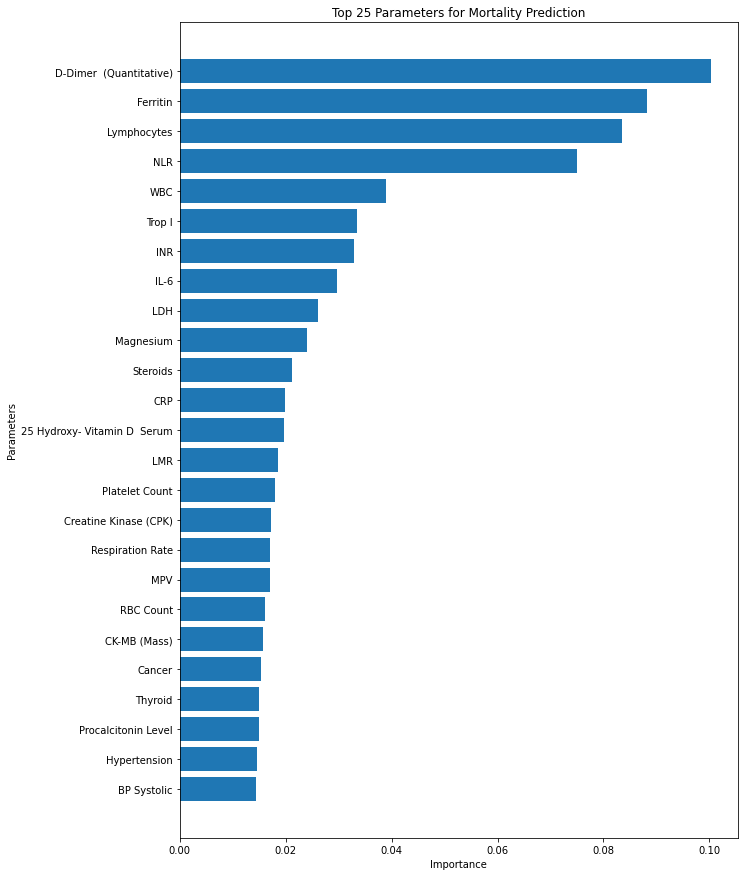

In [10]:
feature_names = []
importances = []

for i in (feature_importances).argsort()[-25:]:
    print (features[i],feature_importances[i])
    feature_names.append(features[i].split("_")[0])
    importances.append(feature_importances[i])

plt.rcParams['figure.figsize'] = [10, 15]
plt.barh(feature_names,importances)
plt.ylabel("Parameters")
plt.xlabel("Importance")
plt.title("Top 25 Parameters for Mortality Prediction")
plt.show()
# plt.savefig(task+"Top25Features.jpg",bbox_inches="tight")

In [11]:
X_patients_train = []
Y_patients_train = []
for patient in train["Patient ID"].unique():
    X_patients_train.append(patient)
    Y_patients_train.append(df_dropped[df_dropped["Patient ID"]==patient].iloc[0][task])

### Perform 5 fold CV for feature selection

In [12]:
selected_features = []

for i in (-feature_importances).argsort()[:15]:
    selected_features.append(features[i])
    rskf = RepeatedStratifiedKFold(n_splits=5,n_repeats=5,random_state=0)
    gt = []
    predicted = []
    proba = []
    trainindices = []
    testindices = []
    predictors = []
    for train_index,test_index in tqdm(rskf.split(X_patients_train,Y_patients_train)):
        trainPatients = get_positions(X_patients_train,train_index)
        testPatients = get_positions(X_patients_train,test_index)

        traindf = train[train["Patient ID"].isin(trainPatients)].drop_duplicates()
        testdf = train[train["Patient ID"].isin(testPatients)].drop_duplicates()

        X_train, Y_train = traindf[selected_features].values, traindf[task].values
        X_test, Y_test = testdf[selected_features].values, testdf[task].values

        scaler = MinMaxScaler(feature_range=(0,1))
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        imputer = SimpleImputer(strategy="median")
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        X_train, Y_train = smote(X_train,Y_train,1)

        clf = xgb.XGBClassifier(objective ='reg:logistic', gamma = 0, learning_rate=0.2, max_delta_step=0, max_depth=4, min_child_weight=0, reg_lambda=7, subsample=1.0)
        clf.fit(X_train,Y_train)
        y_predicted = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)
        gt.append(Y_test)
        predicted.append(y_predicted)
        proba.append(y_proba)
        predictors.append([clf,scaler,imputer])

        trainindices.append(np.where(df_dropped["Patient ID"].isin(trainPatients)==True)[0])
        testindices.append(np.where(df_dropped["Patient ID"].isin(testPatients)==True)[0])

    predicted = np.concatenate(predicted,axis=0)
    gt = np.concatenate(gt,axis=0)
    proba = np.concatenate(proba,axis=0)
    print (task)

    del clf

    print (len(selected_features),average_precision_score(gt,proba[:,1]))    

25it [00:43,  1.75s/it]


Mortality
1 0.4745438364950675


25it [00:30,  1.22s/it]


Mortality
2 0.4767033292408809


25it [00:30,  1.23s/it]


Mortality
3 0.5356367455763341


25it [00:34,  1.40s/it]


Mortality
4 0.5394859932571718


25it [00:33,  1.34s/it]


Mortality
5 0.5654451651687011


25it [00:35,  1.41s/it]


Mortality
6 0.5508001513714397


25it [00:38,  1.53s/it]


Mortality
7 0.5755959341331428


25it [00:44,  1.80s/it]


Mortality
8 0.5847602856571582


25it [01:04,  2.57s/it]


Mortality
9 0.6034923845255296


25it [01:31,  3.65s/it]


Mortality
10 0.5703581794751411


25it [03:54,  9.38s/it]


Mortality
11 0.5854925718735807


25it [03:44,  8.96s/it]


Mortality
12 0.5779486127361739


25it [01:23,  3.35s/it]


Mortality
13 0.5475069754591068


25it [01:09,  2.79s/it]


Mortality
14 0.5618221698187436


25it [01:00,  2.42s/it]

Mortality
15 0.5799131021358599


In [13]:
def getMetrics(testX,testY,models,metric):
    clf = models[0]
    scaler = models[1]
    imputer = models[2]
    
    
    if metric != f1_score:
        ypredicted = clf.predict_proba(imputer.transform(scaler.transform(testX)))
        metric_value  = metric(testY,ypredicted[:,1])
    else:
        ypredicted = clf.predict(imputer.transform(scaler.transform(testX)))
        metric_value  = metric(testY,ypredicted)
    return metric_value

### Select Feature count that achieve max AP score

In [14]:
selected_features = [features[i] for i in (-feature_importances).argsort()[:9]]
selected_features
# selected_features += ['Steroids',"Age"]

['D-Dimer  (Quantitative)_D-Dimer  (Quantitative) Citrate Plasma',
 'Ferritin_Ferritin Serum',
 'Lymphocytes_CBC (Complete Blood Count) EDTA',
 'NLR',
 'WBC',
 'Trop I_Trop I Serum (High Sensitive)',
 'INR_Prothrombin Time (with INR) Citrate Plasma',
 'IL-6_Interleukin -6 (IL-6)',
 'LDH_LDH (Lactate Dehydrogenase) Total   Serum']

### Metrics on the Test Set

In [15]:
X_train, Y_train = train[selected_features].values, train[task].values
X_test, Y_test = test[selected_features].values, test[task].values

scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train, Y_train = smote(X_train,Y_train,1)

# clf = xgb.XGBClassifier(colsample_bytree= 0.9027676504163796,
#  learning_rate=0.1299881198995753,
#  max_depth=2,
#  min_child_weight= 4,
#  n_estimators= 55,
#  subsample= 0.7783799971730078)
clf = linear_model.LogisticRegression()

clf.fit(X_train,Y_train)
y_predicted = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)


print (classification_report(Y_test,y_predicted))
print ("AUC_ROC",roc_auc_score(Y_test,y_proba[:,1])) 
print ("Average Precision",average_precision_score(Y_test,y_proba[:,1])) 
confusion = confusion_matrix(Y_test,y_predicted)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2369
           1       0.71      0.71      0.71       542

    accuracy                           0.89      2911
   macro avg       0.82      0.82      0.82      2911
weighted avg       0.89      0.89      0.89      2911

AUC_ROC 0.9290855593233012
Average Precision 0.8071147371876223


In [16]:
X_test, Y_test = test[selected_features].values, test[task].values

print (classification_report(Y_test,clf.predict(imputer.transform(scaler.transform(X_test)))))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2369
           1       0.71      0.71      0.71       542

    accuracy                           0.89      2911
   macro avg       0.82      0.82      0.82      2911
weighted avg       0.89      0.89      0.89      2911



## Get Metrics over 5 different CV runs

In [17]:
import copy
from sklearn.base import clone
clfs = [xgb.XGBClassifier(colsample_bytree= 0.9027676504163796,
 learning_rate=0.1299881198995753,
 max_depth=2,
 min_child_weight= 4,
 n_estimators= 55,
 subsample= 0.7783799971730078),
       RandomForestClassifier(),
       SVC(probability=True),
       linear_model.LogisticRegression()]

all_predictors = []
for i in clfs:
    rskf = RepeatedStratifiedKFold(n_splits=5,n_repeats=5,random_state=0)
    gt = []
    predicted = []
    proba = []
    trainindices = []
    testindices = []
    predictors = []
    for train_index,test_index in tqdm(rskf.split(X_patients_train,Y_patients_train)):
        trainPatients = get_positions(X_patients_train,train_index)
        testPatients = get_positions(X_patients_train,test_index)

        traindf = train[train["Patient ID"].isin(trainPatients)]
        testdf = train[train["Patient ID"].isin(testPatients)]

        X_train, Y_train = traindf[selected_features].values, traindf[task].values
        X_test, Y_test = testdf[selected_features].values, testdf[task].values

        scaler = MinMaxScaler(feature_range=(0,1))
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        imputer = SimpleImputer(strategy="median")
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        X_train, Y_train = smote(X_train,Y_train,1)
        clf = clone(i)

        clf.fit(X_train,Y_train)
        y_predicted = clf.predict(X_test)
        gt.append(Y_test)
        predicted.append(y_predicted)
        predictors.append([clf,scaler,imputer])

    all_predictors.append(predictors)

    predicted = np.concatenate(predicted,axis=0)
    gt = np.concatenate(gt,axis=0)

    print ("",clf)
    print (task)
    print (classification_report(gt,predicted))
    print ('')

25it [00:15,  1.59it/s]


 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9027676504163796, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.1299881198995753, max_delta_step=0, max_depth=2,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=55, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.7783799971730078, tree_method='exact',
              validate_parameters=1, verbosity=None)
Mortality
              precision    recall  f1-score   support

           0       0.91      0.83      0.87     50345
           1       0.52      0.69      0.59     13340

    accuracy                           0.80     63685
   macro avg       0.71      0.76      0.73     63685
weighted avg       0.83      0.80      0.81     63685




25it [01:10,  2.84s/it]


 RandomForestClassifier()
Mortality
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     50345
           1       0.56      0.53      0.54     13340

    accuracy                           0.82     63685
   macro avg       0.72      0.71      0.71     63685
weighted avg       0.81      0.82      0.81     63685




25it [39:57, 95.89s/it] 


 SVC(probability=True)
Mortality
              precision    recall  f1-score   support

           0       0.90      0.86      0.88     50345
           1       0.56      0.65      0.60     13340

    accuracy                           0.82     63685
   macro avg       0.73      0.76      0.74     63685
weighted avg       0.83      0.82      0.82     63685




25it [00:03,  7.40it/s]


 LogisticRegression()
Mortality
              precision    recall  f1-score   support

           0       0.92      0.84      0.88     50345
           1       0.54      0.72      0.62     13340

    accuracy                           0.81     63685
   macro avg       0.73      0.78      0.75     63685
weighted avg       0.84      0.81      0.82     63685




#### AUC_ROC Score 

In [18]:
means = []
stds = []
X_test, Y_test = test[selected_features].values, test[task].values
for predictors in all_predictors:
    performance = []
    for i in predictors:
        performance.append(getMetrics(testX=X_test,testY=Y_test,metric=roc_auc_score,models = i))
    print (i,"\n",np.mean(performance),"+-",np.std(performance))
    means.append(np.mean(performance))
    stds.append(np.std(performance))

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9027676504163796, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.1299881198995753, max_delta_step=0, max_depth=2,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=55, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.7783799971730078, tree_method='exact',
              validate_parameters=1, verbosity=None), MinMaxScaler(), SimpleImputer(strategy='median')] 
 0.8931507369949174 +- 0.01337319925596464
[RandomForestClassifier(), MinMaxScaler(), SimpleImputer(strategy='median')] 
 0.8583718043174521 +- 0.013749074383864055
[SVC(probability=True), MinMaxScaler(), SimpleImputer(strategy='median')] 
 0.896647035275756 +- 0.01056024623473357
[LogisticRegression(), MinMax

#### Average Precision

In [19]:
means = []
stds = []
X_test, Y_test = test[selected_features].values, test[task].values
for predictors in all_predictors:
    performance = []
    for i in predictors:
        performance.append(getMetrics(testX=X_test,testY=Y_test,metric=average_precision_score,models = i))
    print (i,"\n",np.mean(performance),"+-",np.std(performance))
    means.append(np.mean(performance))
    stds.append(np.std(performance))



[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9027676504163796, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.1299881198995753, max_delta_step=0, max_depth=2,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=55, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.7783799971730078, tree_method='exact',
              validate_parameters=1, verbosity=None), MinMaxScaler(), SimpleImputer(strategy='median')] 
 0.7338416610480185 +- 0.023021170204883683
[RandomForestClassifier(), MinMaxScaler(), SimpleImputer(strategy='median')] 
 0.6169524183640938 +- 0.03573832009590821
[SVC(probability=True), MinMaxScaler(), SimpleImputer(strategy='median')] 
 0.7084850477120819 +- 0.027008082728312746
[LogisticRegression(), MinM

#### F1 Score

In [20]:
means = []
stds = []
X_test, Y_test = test[selected_features].values, test[task].values
for predictors in all_predictors:
    performance = []
    for i in predictors:
        performance.append(getMetrics(testX=X_test,testY=Y_test,metric=f1_score,models = i))
    print (i,"\n",np.mean(performance),"+-",np.std(performance))
    means.append(np.mean(performance))
    stds.append(np.std(performance))



[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9027676504163796, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.1299881198995753, max_delta_step=0, max_depth=2,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=55, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.7783799971730078, tree_method='exact',
              validate_parameters=1, verbosity=None), MinMaxScaler(), SimpleImputer(strategy='median')] 
 0.6372996700982129 +- 0.033718329182173865
[RandomForestClassifier(), MinMaxScaler(), SimpleImputer(strategy='median')] 
 0.5586965743310359 +- 0.03904276467940977
[SVC(probability=True), MinMaxScaler(), SimpleImputer(strategy='median')] 
 0.6585822697441673 +- 0.027439361950546862
[LogisticRegression(), MinM